In [1]:
from importlib import reload
import matplotlib.pyplot as plt
import cryptoz
from cryptoz import stats
import pandas as pd
import numpy as np

In [2]:
tri_cmap = cryptoz.plot.continuous_cmap(['coral', 'white', 'steelblue'])
pos_duo_cmap = cryptoz.plot.continuous_cmap(['lightblue', 'steelblue'])
neg_duo_cmap = cryptoz.plot.continuous_cmap(['coral', 'lightyellow'])

# data

In [3]:
from_dt = cryptoz.data.ago_dt(days=3)
to_dt = cryptoz.data.now_dt()
period = cryptoz.data.Period.M5

In [4]:
ohlc = cryptoz.data.chartdata('(USDT_+)', from_dt, to_dt, period)

In [5]:
reload(cryptoz.plot)
df = cryptoz.utils.to_df(ohlc, 'C').resample('1h').last()

   count         mean          std      min        25%       50%         75%  \
0  876.0  1214.153734  3035.188073  0.08748  19.631546  144.5619  544.485117   

       max  
0  11733.0  


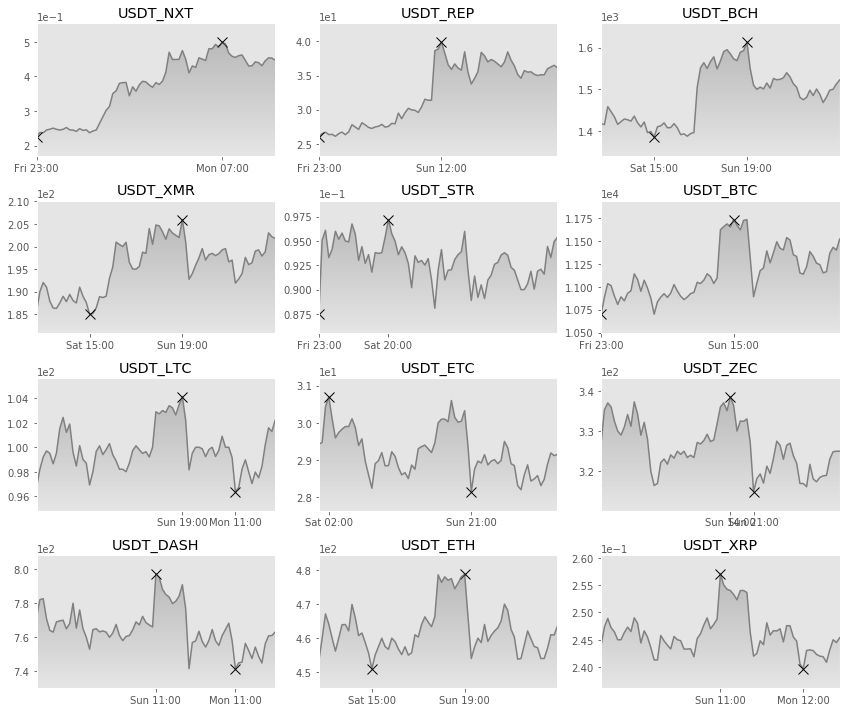

In [6]:
ranker = lambda sr: 1 - sr.iloc[-1] / sr.min()
cryptoz.plot.time_series(df, ranker=ranker)

In [7]:
df = cryptoz.utils.to_df(ohlc, 'C').pct_change().fillna(0)

     count      mean       std       min       25%  50%       75%       max
0  10368.0  0.000182  0.007158 -0.072595 -0.002554  0.0  0.003032  0.093333


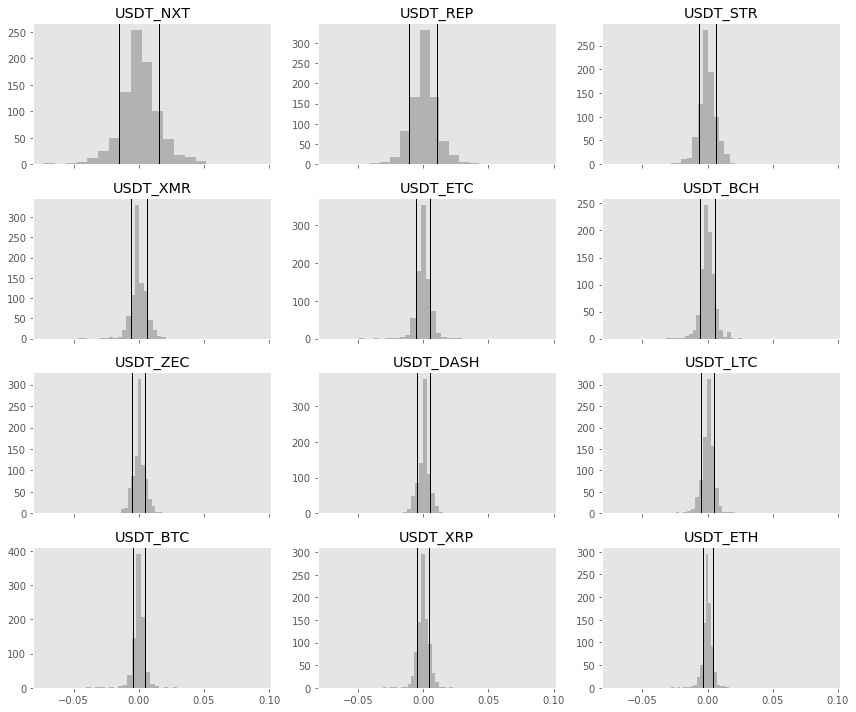

In [8]:
ranker = lambda sr: 1 / sr.std()
axvlines = [lambda sr: -sr.std(), lambda sr: sr.std()]
cryptoz.plot.hist(df, axvlines=axvlines, ranker=ranker)

# perf

   count      mean       std  min       25%       50%       75%  max
0  192.0 -0.412719  0.691025 -1.0 -0.941623 -0.749903 -0.040368  1.0


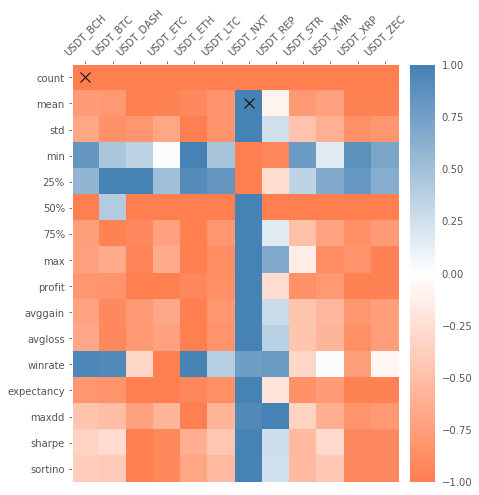

In [9]:
df = stats.perf.score_matrix(ohlc)

norm = cryptoz.plot.midpoint_norm(df.values.flatten(), 0)
cryptoz.plot.matrix(df, cmap=tri_cmap, norm=norm)

# recovery

In [10]:
df = stats.recovery.dd(ohlc)

cryptoz.utils.describe_df(df)

,count,mean,std,min,25%,50%,75%,max
USDT_BCH,864.0,-0.048768,0.025775,-0.118972,-0.070373,-0.046194,-0.026899,-0.001908
USDT_BTC,864.0,-0.030549,0.019690,-0.116720,-0.042669,-0.028280,-0.014497,-0.001948
USDT_DASH,864.0,-0.043270,0.021743,-0.103714,-0.063502,-0.036127,-0.026864,-0.001247
USDT_ETC,864.0,-0.053559,0.022415,-0.109744,-0.069919,-0.057948,-0.033387,-0.003268
USDT_ETH,864.0,-0.033023,0.017841,-0.088915,-0.047215,-0.032653,-0.016375,-0.000273
USDT_LTC,864.0,-0.043367,0.025671,-0.116541,-0.062359,-0.039407,-0.020241,-0.000992
USDT_NXT,864.0,-0.077522,0.045638,-0.222702,-0.107063,-0.073171,-0.038622,-0.002080
USDT_REP,864.0,-0.137394,0.109548,-0.310056,-0.245388,-0.175605,-0.027777,-0.000945
USDT_STR,864.0,-0.055685,0.023125,-0.124025,-0.073080,-0.056399,-0.041988,-0.005064
USDT_XMR,864.0,-0.037869,0.017535,-0.109039,-0.049785,-0.038140,-0.024126,0.000000


In [11]:
stats.recovery.dd_now(ohlc)

USDT_REP    -0.243989
USDT_NXT    -0.120251
USDT_BCH    -0.063015
USDT_DASH   -0.056827
USDT_ETC    -0.056329
USDT_XRP    -0.055465
USDT_ZEC    -0.046921
USDT_ETH    -0.040176
USDT_LTC    -0.039335
USDT_STR    -0.028381
USDT_BTC    -0.027674
USDT_XMR    -0.025470
dtype: float64

   count    mean       std       min       25%       50%       75%       max
0  876.0 -0.0533  0.048093 -0.298496 -0.064955 -0.042537 -0.024844 -0.004713


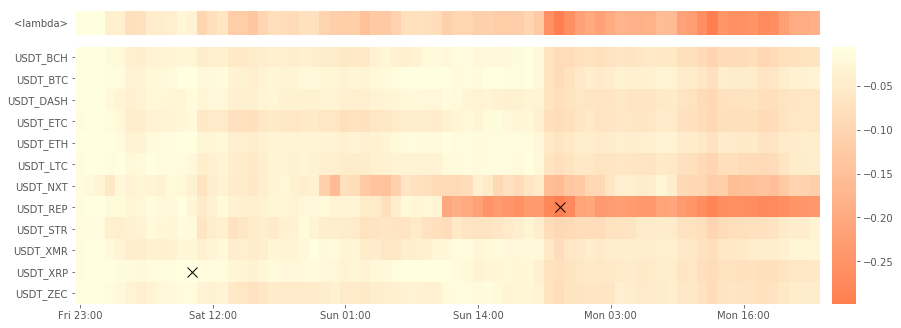

In [35]:
df = stats.recovery.resample_dd(ohlc, lambda df: df.mean(), '1h')

cryptoz.plot.evolution(df, cmap=neg_duo_cmap)

In [13]:
stats.recovery.maxdd_duration(ohlc)

USDT_NXT    0 days 01:00:00
USDT_XMR    0 days 01:40:00
USDT_BTC    0 days 01:45:00
USDT_ETC    0 days 05:50:00
USDT_ZEC    0 days 09:25:00
USDT_ETH    0 days 10:00:00
USDT_DASH   0 days 10:05:00
USDT_XRP    0 days 10:05:00
USDT_REP    0 days 11:05:00
USDT_BCH    0 days 16:45:00
USDT_LTC    0 days 17:00:00
USDT_STR    1 days 01:05:00
dtype: timedelta64[ns]

In [14]:
df = cryptoz.utils.to_df(stats.recovery.details(ohlc), 'dd_len')

cryptoz.utils.describe_df(df)

,count,mean,std,min,25%,50%,75%,max
USDT_BCH,12.0,35.166667,67.439985,1.0,1.00,5.0,18.25,201.0
USDT_BTC,15.0,10.266667,16.210520,1.0,1.00,2.0,12.50,54.0
USDT_DASH,6.0,47.833333,71.532976,1.0,2.25,3.0,91.50,157.0
USDT_ETC,6.0,36.666667,56.425762,2.0,2.25,4.0,53.75,138.0
USDT_ETH,12.0,17.833333,35.936392,1.0,1.00,1.5,9.00,120.0
USDT_LTC,13.0,26.307692,56.008012,1.0,1.00,4.0,16.00,204.0
USDT_NXT,24.0,11.750000,27.905508,1.0,1.00,2.0,9.50,137.0
USDT_REP,21.0,12.190476,29.249990,1.0,1.00,2.0,6.00,133.0
USDT_STR,12.0,30.166667,85.444116,1.0,2.50,3.5,9.75,301.0
USDT_XMR,10.0,26.600000,48.272836,1.0,1.00,2.0,26.00,154.0


# corr

   count      mean       std       min       25%       50%       75%  max
0  144.0  0.502741  0.381097 -0.421078  0.277151  0.602089  0.814815  1.0


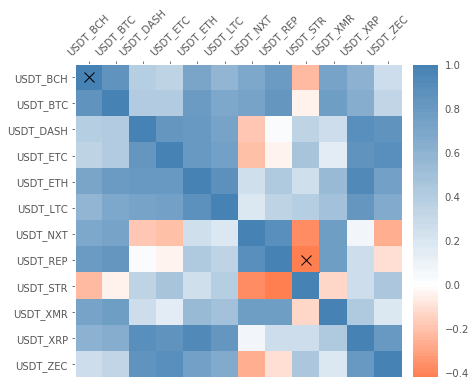

In [15]:
df = stats.corr.corr(cryptoz.utils.to_df(ohlc, 'C'))

norm = cryptoz.plot.midpoint_norm(df.values.flatten(), 0)
cryptoz.plot.matrix(df, cmap=tri_cmap, norm=norm)

   count      mean       std       min       25%       50%       75%       max
0  730.0  0.441784  0.417017 -0.793081  0.173819  0.520208  0.789061  0.993005


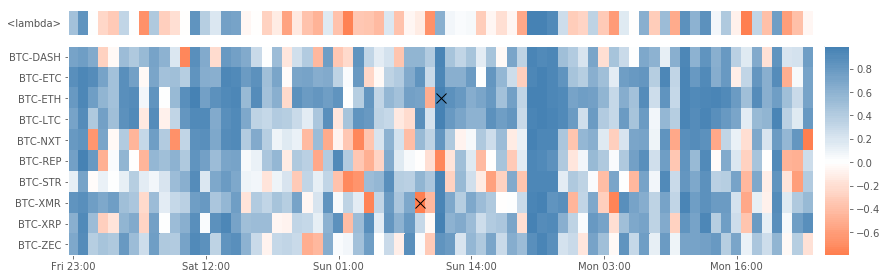

In [16]:
import re

df = cryptoz.utils.to_df(ohlc, 'C')
df = stats.corr.resample_corr(df, '1h')
regex = re.compile('(USDT_BTC-+)')
df = df[list(filter(regex.search, df.columns))]
df.columns = list(map(lambda x: re.sub(r'(USDT_)', '', x), df.columns))

norm = cryptoz.plot.midpoint_norm(df.values.flatten(), 0)
cryptoz.plot.evolution(df, cmap=tri_cmap, norm=norm)

# depth

In [17]:
orderbooks = cryptoz.data.orderbooks('(USDT_+)')

    count         mean            std            min            25%       50%  \
0  2400.0 -2616.134667  170748.186356 -432573.298191 -105456.990543  0.701142   

             75%           max  
0  108325.717041  470529.48143  


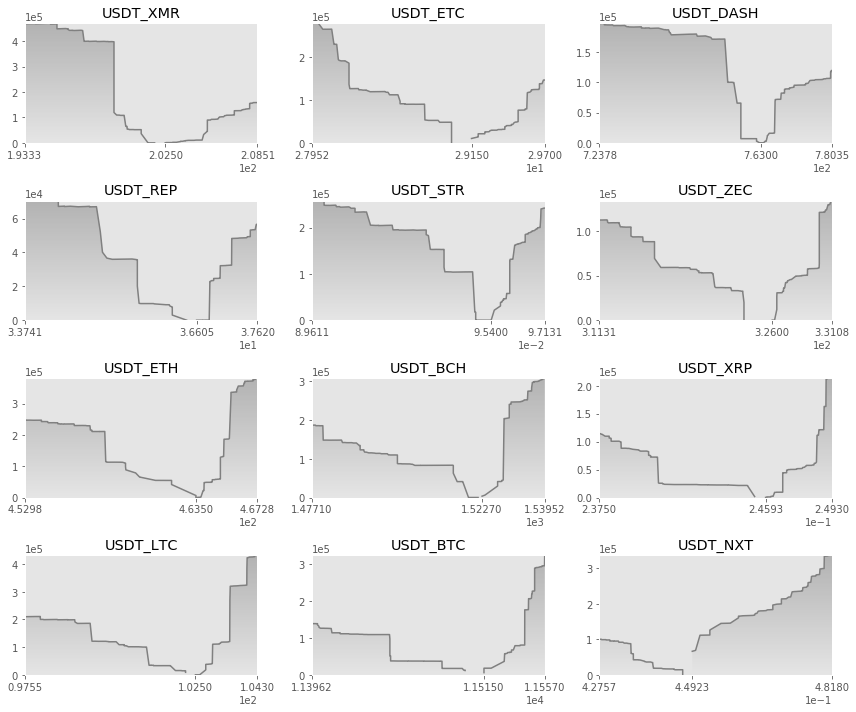

In [18]:
cryptoz.plot.depth(orderbooks, ranker=lambda sr: 1 - sr.max() / abs(sr.min()))

# score

In [19]:
def BB_bands(sr, window, std_n):
    rollmean_sr = sr.rolling(window=window, min_periods=1).mean()
    rollstd_sr = sr.rolling(window=window, min_periods=1).std()
    upper_band_sr = rollmean_sr + std_n * rollstd_sr
    lower_band_sr = rollmean_sr - std_n * rollstd_sr
    return upper_band_sr, lower_band_sr

def corridor(sr1, sr2):
    return sr1 - sr2

def normalize(sr):
    return (sr - sr.mean()) / sr.std()

   count      mean       std   min        25%       50%       75%   max
0  756.0 -0.682516  9.114623 -12.0 -10.355565 -1.285064  9.308541  12.0


/Users/olegpolakow/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


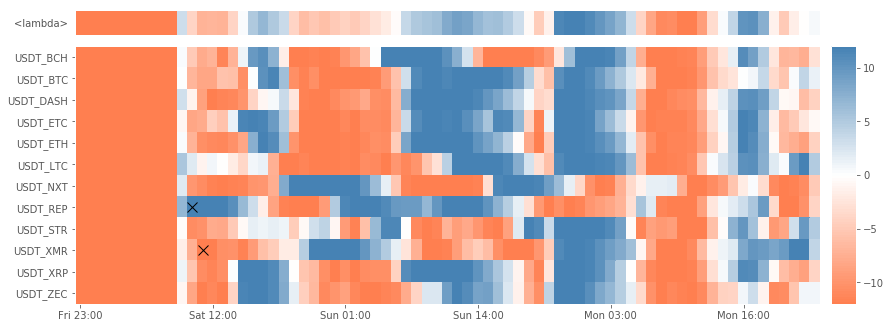

In [38]:
window = 120
std_n = 3

strategy = lambda ohlc_df: normalize(corridor(*BB_bands(ohlc_df['C'], window, 3)))
df1 = pd.DataFrame({pair: strategy(ohlc_df) for pair, ohlc_df in ohlc.items()})
score1_df = cryptoz.score.rolling_apply(df1, window=window, min_periods=window)

norm = cryptoz.plot.midpoint_norm(score1_df.values.flatten(), 0)
cryptoz.plot.evolution(score1_df.resample('1h').sum(), cmap=tri_cmap, norm=norm)

   count      mean       std        min       25%       50%       75%  \
0  756.0  1.188886  6.435213 -11.735495 -4.026951  1.795168  6.645293   

         max  
0  11.784201  


/Users/olegpolakow/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


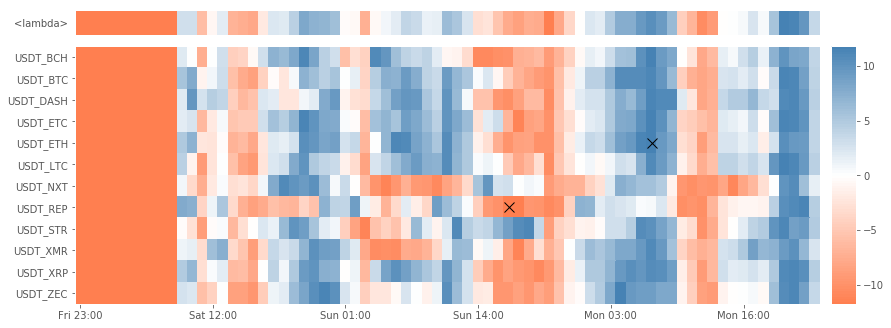

In [39]:
strategy = lambda ohlc_df: normalize(corridor(ohlc_df['C'], ohlc_df['C'].rolling(window=window, min_periods=1).mean()))
df2 = pd.DataFrame({pair: strategy(ohlc_df) for pair, ohlc_df in ohlc.items()})
score2_df = cryptoz.score.rolling_apply(df2, window=window, min_periods=window)

norm = cryptoz.plot.midpoint_norm(score2_df.values.flatten(), 0)
cryptoz.plot.evolution(score2_df.resample('1h').sum(), cmap=tri_cmap, norm=norm)

Rules
1. narrow corridor and price over MA -> trend up -> buy
2. wide corridor and price below MA -> oversold -> buy
3. narrow corridor and price below MA -> trend down -> sell
4. wide corridor and price above MA -> overbought -> sell

   count      mean       std        min       25%       50%      75%  \
0  756.0 -2.431309  5.831511 -11.531652 -7.238928 -3.519517  1.82237   

         max  
0  11.600157  


/Users/olegpolakow/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


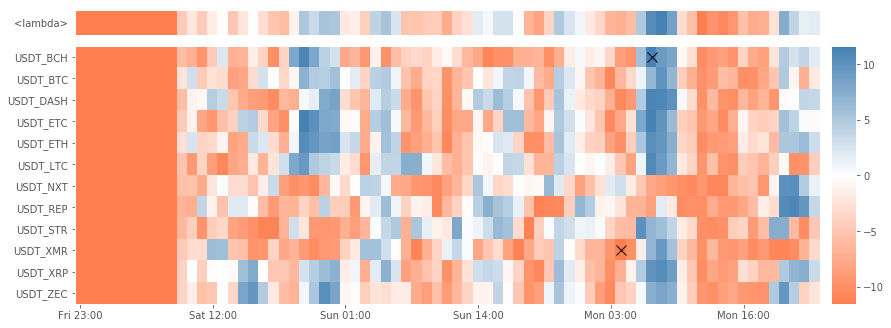

In [40]:
score_df = cryptoz.score.diff(score1_df, score2_df, axis=0) # axis 0: pair-local score

norm = cryptoz.plot.midpoint_norm(score_df.values.flatten(), 0)
cryptoz.plot.evolution(score_df.resample('1h').sum(), cmap=tri_cmap, norm=norm)